# Read and review time-series history files in parquet format

In [56]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta
import variables as vars
plt.rcParams["figure.figsize"] = (10,6)
import pytz
from datetime import datetime as dt, timedelta, timezone
%matplotlib inline

In [57]:
file_path_and_name = f'{vars.parquet_files_output_dir}{vars.intra_daily_history_file_prefix}.parquet'

In [58]:
data = pd.read_parquet(file_path_and_name)
data.info()

FileNotFoundError: [Errno 2] No such file or directory: './outputs/parquet_files/history_intra_daily.parquet'

In [46]:
# check top rows of data
data.head()

,time,queueid,aht,callvolume
0,2014-05-03 10:00:00,Org_0_0_59782,7.8930,53.0839
1,2014-05-03 10:15:00,Org_0_0_59782,7.7860,55.6670
2,2014-05-03 10:30:00,Org_0_0_59782,7.7964,56.1587
3,2014-05-03 10:45:00,Org_0_0_59782,7.8126,57.7250
4,2014-05-03 11:00:00,Org_0_0_59782,7.7985,59.4955


# Key Stats about the data

### Number of rows, number of queues

In [47]:
num_rows = data.shape[0]
print(f"number of rows in history: {num_rows}")

unique_queues = data['queueid'].unique()

print(f"number of queues in history: {len(unique_queues)}")
print(f"list of queue ids: {unique_queues}")

number of rows in history: 26876
number of queues in history: 1
list of queue ids: ['Org_0_0_59782']


### History start and end dates

In [48]:
history_start_time = data['time'].min()
history_end_time = data['time'].max()
print(f"history_start_time: {history_start_time}")
print(f"history_end_time: {history_end_time}")

history_start_time: 2014-05-03 10:00:00
history_end_time: 2017-05-01 17:45:00


 # Charting Volumes and AHT by date
 Original data is by time-intervals (15 minute intervals). 

### add a date column

In [49]:
# add a date column and a weekday column 
data['date'] = data['time'].apply(lambda t: t.date())
data['weekday'] = data['time'].apply(lambda t: t.weekday()+1)
#data['yrmt'] = pd.DatetimeIndex(data['time']).year * 100 + pd.DatetimeIndex(data['time']).month
data.head()

,time,queueid,aht,callvolume,date,weekday
0,2014-05-03 10:00:00,Org_0_0_59782,7.8930,53.0839,2014-05-03,6
1,2014-05-03 10:15:00,Org_0_0_59782,7.7860,55.6670,2014-05-03,6
2,2014-05-03 10:30:00,Org_0_0_59782,7.7964,56.1587,2014-05-03,6
3,2014-05-03 10:45:00,Org_0_0_59782,7.8126,57.7250,2014-05-03,6
4,2014-05-03 11:00:00,Org_0_0_59782,7.7985,59.4955,2014-05-03,6


### Aggregate by date
#### volumes are sum'ed over per day
#### AHT are averaged per day

In [50]:
groupby_cols = ['queueid', 'date']
daily_data = data.groupby(groupby_cols).agg( { 'callvolume': ['sum'], 'aht': ['mean'] } )
daily_data.columns = ['_'.join(col).strip() for col in daily_data.columns.values]
daily_data.reset_index(inplace=True)
daily_data.head()

,queueid,date,callvolume_sum,aht_mean
0,Org_0_0_59782,2014-05-03,688.3282,7.829950
1,Org_0_0_59782,2014-05-05,2114.7250,7.784997
2,Org_0_0_59782,2014-05-06,1946.8052,7.615462
3,Org_0_0_59782,2014-05-07,1751.2259,6.977347
4,Org_0_0_59782,2014-05-08,2270.5494,8.222994


### Chart of Volume and AHT per queue by Day
#### Side by Side charts

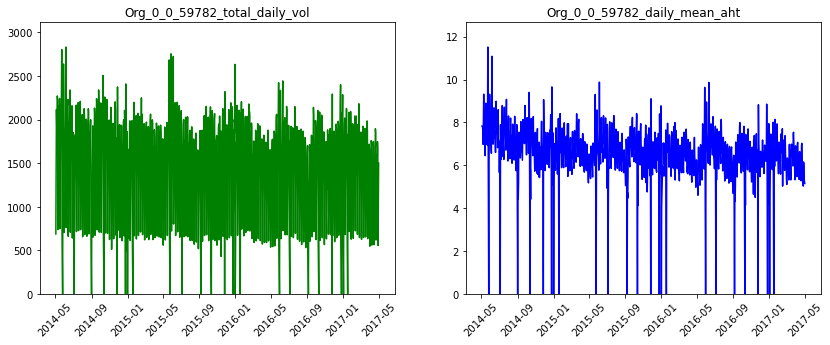

In [51]:
rows, cols = len(unique_queues), 2
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize = (14, 5*rows), sharex=True, sharey=False)

y_max_vol = daily_data['callvolume_sum'].max()
y_max_aht = daily_data['aht_mean'].max()
for i, queue in enumerate(unique_queues):
    idx = daily_data['queueid'] == queue
    df = daily_data.loc[idx]    
    
    ax = axs[i, 0] if rows > 1 else axs[0]
    ax.plot(df['date'], df['callvolume_sum'], c = 'green')  
    ax.set_ylim([0, y_max_vol * 1.1])
    ax.set_title(queue+'_total_daily_vol')
    for tick in ax.get_xticklabels(): tick.set_rotation(45)
    
    ax = axs[i, 1] if rows > 1 else axs[1]
    ax.plot(df['date'], df['aht_mean'], c = 'blue')  
    ax.set_ylim([0, y_max_aht * 1.1])
    ax.set_title(queue+'_daily_mean_aht')
    for tick in ax.get_xticklabels(): tick.set_rotation(45)

#plt.legend()

### Chart of Volumes by Day - All Queues Together

Text(0.5, 1.0, 'Daily Volumes')

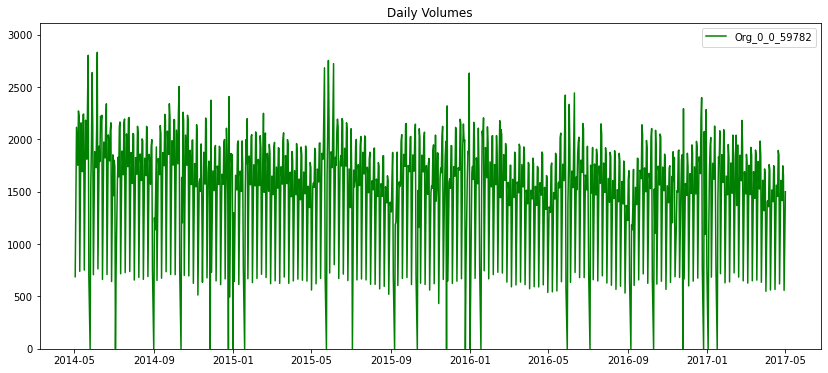

In [52]:
plt.rcParams["figure.figsize"] = (14,6)
y_max = daily_data['callvolume_sum'].max()
for i, queue in enumerate(unique_queues):
    idx = daily_data['queueid'] == queue
    df = daily_data.loc[idx]    
    plt.plot(df['date'], df['callvolume_sum'], label=queue, c='green')
    plt.ylim(bottom=0., top=y_max*1.1)
plt.legend()
plt.title("Daily Volumes")

### Chart of AHT by Day - All Queues Together

Text(0.5, 1.0, 'AHT by Day')

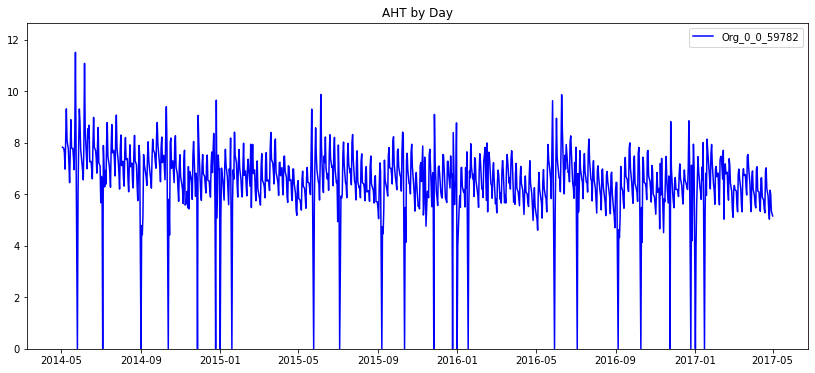

In [53]:
plt.rcParams["figure.figsize"] = (14,6)
y_max = daily_data['aht_mean'].max()
for i, queue in enumerate(unique_queues):
    idx = daily_data['queueid'] == queue
    df = daily_data.loc[idx]    
    plt.plot(df['date'], df['aht_mean'], label=queue, c='blue')
    plt.ylim(bottom=0., top=y_max*1.1)
plt.legend()
plt.title("AHT by Day")

### Chart of Volumes by Day - Each Queue Separate

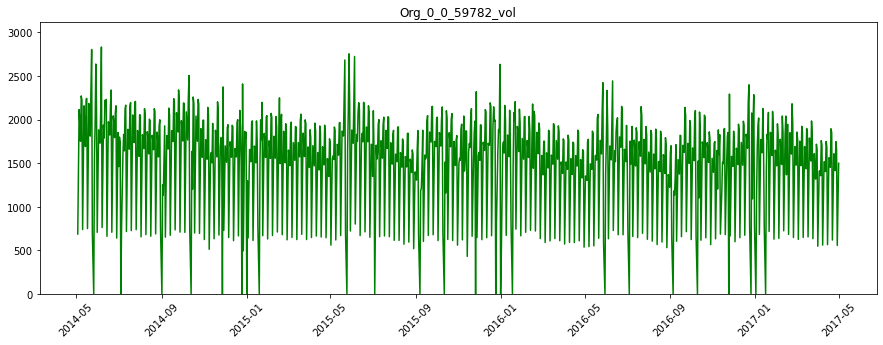

In [54]:
y_max = daily_data['callvolume_sum'].max()
if len(unique_queues) > 1:
    fig, axs = plt.subplots(len(unique_queues), figsize = (15, 5*len(unique_queues)), sharex=True, sharey=False)
else: 
    fig, axs = plt.subplots(figsize = (15, 5*len(unique_queues)),)

for i, queue in enumerate(unique_queues):
    idx = daily_data['queueid'] == queue
    df = daily_data.loc[idx]    
    
    ax = axs[i] if rows > 1 else axs                   
    ax.plot(df['date'], df['callvolume_sum'], c = 'green')  
    plt.ylim(bottom=0., top=y_max*1.1)
    ax.set_title(f'{queue}_vol')
    for tick in ax.get_xticklabels(): tick.set_rotation(45)

### Chart of AHT by Day - Each Queue Separate

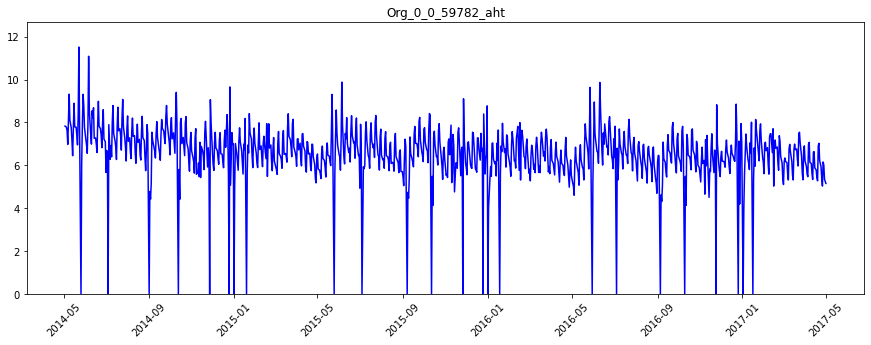

In [55]:
y_max = daily_data['aht_mean'].max()
if len(unique_queues) > 1:
    fig, axs = plt.subplots(len(unique_queues), figsize = (15, 5*len(unique_queues)), sharex=True, sharey=False)
else: 
    fig, axs = plt.subplots(figsize = (15, 5*len(unique_queues)),)

for i, queue in enumerate(unique_queues):
    idx = daily_data['queueid'] == queue
    df = daily_data.loc[idx]    
    
    ax = axs[i] if rows > 1 else axs                   
    ax.plot(df['date'], df['aht_mean'], c = 'blue')  
    ax.set_title(f'{queue}_aht')
    plt.ylim(bottom=0., top=y_max*1.1)
    for tick in ax.get_xticklabels():        
        tick.set_rotation(45)